# 🥇 Olympic Figure Skating: Art vs Technical Power (2006–2026)
## Do Olympic medals depend more on jumps (TES) or artistry (PCS)?

---

> **Story hook:** Figure skating looks like art — but the scoreboard can reward power. This project tests what *actually* wins at the Olympics for **Men’s** and **Women’s Singles** from **Torino 2006 → Milano Cortina 2026**.

**Core question:** *At the Olympics, do medals depend more on Technical Element Score (TES) or Program Component Score (PCS), and has that balance shifted over time?*

---

### What you’ll see
- A clean Olympic-only dataset (SP + FS) for Men & Women Singles
- Strong data validation and cleaning notes
- “Hero” visuals that show **where medalists cluster** in TES vs PCS space
- A simple metric that makes eras comparable: **Tech Dominance = TES / (TES + PCS)**

---

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Optional interactive charts
import plotly.express as px

DATA_DIR = Path("..") / "data_clean"  # change if needed
RAW_DIR  = Path("..") / "data_raw"    # change if needed

# If running locally, update these paths to where your files live
LONG_PATH = Path("./olympics_singles_long.xlsx")
AGG_PATH  = Path("./olympics_singles_agg.xlsx")

# Notebook style (feel free to tweak)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12


# Auto-detect files in this environment (optional)
if not LONG_PATH.exists():
    LONG_PATH = Path("/mnt/data/olympics_singles_long.xlsx")
if not AGG_PATH.exists():
    AGG_PATH = Path("/mnt/data/olympics_singles_agg.xlsx")


---
## 1) Dataset overview

We use **two tables**:

1. **Segment-level (long)**: one row per skater per segment (SP or FS).
2. **Aggregated (per Olympics)**: one row per skater per Olympics with SP + FS combined.

This design keeps the data clean and makes analysis + website filters simple.

---

In [2]:
# Load the two tables you created manually
long_df = pd.read_excel(LONG_PATH)
agg_df  = pd.read_excel(AGG_PATH)

long_df.head(), agg_df.head()

(   year gender segment rank_segment             skater nation    tss    tes  \
 0  2006      M      SP            1   PLUSHENKO Evgeni    RUS  90.66  49.69   
 1  2006      M      SP            2        WEIR Johnny    USA  80.00  40.99   
 2  2006      M      SP            3   LAMBIEL Stephane    SUI  79.04  40.61   
 3  2006      M      SP            4      JOUBERT Brian    FRA  77.77  40.59   
 4  2006      M      SP            5  TAKAHASHI Daisuke    JPN  73.77  38.45   
 
      pcs  ded  
 0  40.97    0  
 1  39.01    0  
 2  38.43    0  
 3  37.18    0  
 4  35.32    0  ,
    year gender final_rank             skater nation  total_tss  sp_rank  \
 0  2026      M          1  SHAIDOROV Mikhail    KAZ     291.58        5   
 1  2026      M          2      KAGIYAMA Yuma    JPN     280.06        2   
 2  2026      M          3          SATO Shun    JPN     274.90        9   
 3  2026      M          4        CHA Junhwan    KOR     273.92        6   
 4  2026      M          5    GOGOL

In [3]:
print("LONG:", long_df.shape); display(long_df.head(3))
print("AGG :", agg_df.shape); display(agg_df.head(3))


LONG: (646, 10)


,year,gender,segment,rank_segment,skater,nation,tss,tes,pcs,ded
0,2006,M,SP,1,PLUSHENKO Evgeni,RUS,90.66,49.69,40.97,0
1,2006,M,SP,2,WEIR Johnny,USA,80.00,40.99,39.01,0
2,2006,M,SP,3,LAMBIEL Stephane,SUI,79.04,40.61,38.43,0


AGG : (357, 18)


,year,gender,final_rank,skater,nation,total_tss,sp_rank,fs_rank,tss_sp,tes_sp,pcs_sp,tss_fs,tes_fs,pcs_fs,tes_total,pcs_total,tech_dominance,medal
0,2026,M,1,SHAIDOROV Mikhail,KAZ,291.58,5,1.0,92.94,52.45,40.49,198.64,114.68,83.96,167.13,124.45,0.573187,1
1,2026,M,2,KAGIYAMA Yuma,JPN,280.06,2,6.0,103.07,56.50,46.57,176.99,92.15,85.84,148.65,132.41,0.528891,2
2,2026,M,3,SATO Shun,JPN,274.90,9,3.0,88.70,46.77,41.93,186.20,101.85,84.35,148.62,126.28,0.540633,3


---
## 2) Quick validation checks

Before analysis, we validate:

- We have **6 Olympics** (2006–2026)
- We have both genders
- Medal rows count makes sense (6 Olympics × 2 genders × 3 medals = **36 medalists**)
- Tech dominance values are in a realistic range

These checks are fast, but they prevent hours of confusion later.

---

In [4]:
# Basic sanity checks
years = sorted(agg_df["year"].unique())
genders = sorted(agg_df["gender"].unique())

print("Years:", years)
print("Genders:", genders)

# Medal encoding check (your sheet uses numeric codes)
# 0=None, 1=Gold, 2=Silver, 3=Bronze
medal_counts = agg_df["medal"].value_counts(dropna=False).sort_index()
print("\nMedal counts (0=None, 1=Gold, 2=Silver, 3=Bronze):")
print(medal_counts)

expected_medalists = len(years) * len(genders) * 3
actual_medalists = (agg_df["medal"].isin([1,2,3])).sum()
print(f"\nExpected medalists: {expected_medalists} | Actual medalists: {actual_medalists}")

# Tech dominance range
print("\nTech dominance summary:")
print(agg_df["tech_dominance"].describe())

# Missing FS check (skaters who did not advance)
missing_fs = agg_df["tss_fs"].isna().sum() if "tss_fs" in agg_df.columns else 0
print("\nMissing FS rows (did not qualify/withdrew):", missing_fs)


Years: [np.int64(2006), np.int64(2010), np.int64(2014), np.int64(2018), np.int64(2022), np.int64(2026)]
Genders: ['M', 'W']

Medal counts (0=None, 1=Gold, 2=Silver, 3=Bronze):
medal
0    321
1     12
2     12
3     12
Name: count, dtype: int64

Expected medalists: 36 | Actual medalists: 36

Tech dominance summary:
count    357.000000
mean       0.501765
std        0.055057
min        0.000000
25%        0.489235
50%        0.508396
75%        0.524204
max        0.590106
Name: tech_dominance, dtype: float64

Missing FS rows (did not qualify/withdrew): 0


---
## 3) Cleaning and standardization

Even with manual collection, we standardize a few things so plots are consistent:

- Convert numeric columns to numeric
- Map `medal` codes to labels
- Create a consistent `event` label

---

In [5]:
# Make a copy so we don't mutate original dataframes
long = long_df.copy()
agg  = agg_df.copy()

# Coerce numerics
num_cols_long = ["tss","tes","pcs","ded"]
for c in num_cols_long:
    long[c] = pd.to_numeric(long[c], errors="coerce")

num_cols_agg = ["total_tss","tss_sp","tes_sp","pcs_sp","tss_fs","tes_fs","pcs_fs","tes_total","pcs_total","tech_dominance"]
for c in num_cols_agg:
    if c in agg.columns:
        agg[c] = pd.to_numeric(agg[c], errors="coerce")

# Medal labels
medal_map = {0:"None", 1:"Gold", 2:"Silver", 3:"Bronze"}
agg["medal_label"] = agg["medal"].map(medal_map)

# Ensure year is int for sorting
agg["year"] = agg["year"].astype(int)
long["year"] = long["year"].astype(int)

display(agg[["year","gender","skater","nation","final_rank","medal_label","tech_dominance"]].head(10))


,year,gender,skater,nation,final_rank,medal_label,tech_dominance
0,2026,M,SHAIDOROV Mikhail,KAZ,1,Gold,0.573187
1,2026,M,KAGIYAMA Yuma,JPN,2,Silver,0.528891
2,2026,M,SATO Shun,JPN,3,Bronze,0.540633
3,2026,M,CHA Junhwan,KOR,4,None,0.528299
4,2026,M,GOGOLEV Stephen,CAN,5,None,0.553181
5,2026,M,GUMENNIK Petr,AIN,6,None,0.561447
6,2026,M,SIAO HIM FA Adam,FRA,7,None,0.526289
7,2026,M,MALININ Ilia,USA,8,None,0.521445
8,2026,M,GRASSL Daniel,ITA,9,None,0.536650
9,2026,M,EGADZE Nika,GEO,10,None,0.543805


---
## 4) A quick scoring refresher (why TES vs PCS matters)

Olympic singles uses two segments:

- **Short Program (SP)**
- **Free Skate (FS)**

Each segment has:

- **TES** (Technical Element Score): jumps, spins, step sequences
- **PCS** (Program Component Score): skating skills, transitions, performance, composition, interpretation

The debate we test:

> **Does Olympic success track more with technical power (TES) or artistry (PCS)?**

---

---
## 5) The one metric that makes eras comparable

Raw scores vary by era, segment, and gender. To compare fairly, we use:

**Tech Dominance**

\[
\text{Tech Dominance} = \frac{TES_{total}}{TES_{total} + PCS_{total}}
\]

Interpretation:

- **0.50** means the skater’s TES and PCS contribute roughly equally
- **0.65** means the skater’s score is **more tech-driven**

---

In [6]:
# Confirm we have tech_dominance; if not, compute it
if "tech_dominance" not in agg.columns or agg["tech_dominance"].isna().all():
    agg["tech_dominance"] = agg["tes_total"] / (agg["tes_total"] + agg["pcs_total"])

agg[["year","gender","skater","tes_total","pcs_total","tech_dominance"]].head()

,year,gender,skater,tes_total,pcs_total,tech_dominance
0,2026,M,SHAIDOROV Mikhail,167.13,124.45,0.573187
1,2026,M,KAGIYAMA Yuma,148.65,132.41,0.528891
2,2026,M,SATO Shun,148.62,126.28,0.540633
3,2026,M,CHA Junhwan,145.24,129.68,0.528299
4,2026,M,GOGOLEV Stephen,151.45,122.33,0.553181


---
## 6) Hero chart: Where do medalists live in TES vs PCS space?

This chart is the fastest way to *see* what wins.

- **X:** TES_total (technical power)
- **Y:** PCS_total (artistry)
- **Color:** medal

If medals cluster far to the right, it suggests **TES dominates**.
If medals cluster high up, it suggests **PCS dominates**.

---

In [7]:
# Hero scatter (Plotly for interactivity in notebook)
fig = px.scatter(
    agg.dropna(subset=["tes_total","pcs_total"]),
    x="tes_total",
    y="pcs_total",
    color="medal_label",
    symbol="gender",
    hover_data=["year","skater","nation","final_rank","tes_total","pcs_total","tech_dominance"],
    title="Olympic Singles: TES_total vs PCS_total (2006–2026)",
    opacity=0.8
)
fig.update_layout(legend_title_text="Medal")
fig.show()


---
## 7) Trend: Is Olympic skating becoming more tech-dominant?

We look at **average Tech Dominance** by year, separately for:

- Medalists (Gold/Silver/Bronze)
- Everyone

This gives a clean story: *is the sport shifting toward technical power over time?*

---

In [8]:
medalists = agg[agg["medal"].isin([1,2,3])].copy()

trend_all = agg.groupby(["year","gender"], as_index=False)["tech_dominance"].mean()
trend_med = medalists.groupby(["year","gender"], as_index=False)["tech_dominance"].mean()

trend_all["group"] = "All skaters"
trend_med["group"] = "Medalists"

trend = pd.concat([trend_all, trend_med], ignore_index=True)

fig = px.line(
    trend,
    x="year",
    y="tech_dominance",
    color="gender",
    line_dash="group",
    markers=True,
    title="Tech Dominance over time (All vs Medalists)"
)
fig.update_yaxes(tickformat=".0%")
fig.show()


---
## 8) Medal recipe: How much of a medalist’s score is TES vs PCS?

For each Olympic year and gender, we compute the average share of:

- TES_total
- PCS_total

among medalists.

This makes the “recipe for a medal” easy to understand.

---

In [9]:
med = medalists.dropna(subset=["tes_total","pcs_total"]).copy()
med["tes_share"] = med["tes_total"] / (med["tes_total"] + med["pcs_total"])
med["pcs_share"] = 1 - med["tes_share"]

recipe = med.groupby(["year","gender"], as_index=False)[["tes_share","pcs_share"]].mean()

# Convert to long for stacked bar
recipe_long = recipe.melt(id_vars=["year","gender"], value_vars=["tes_share","pcs_share"],
                          var_name="component", value_name="share")

recipe_long["component"] = recipe_long["component"].map({"tes_share":"TES share", "pcs_share":"PCS share"})

fig = px.bar(
    recipe_long,
    x="year",
    y="share",
    color="component",
    facet_row="gender",
    title="Medalists' score composition (TES vs PCS)"
)
fig.update_yaxes(tickformat=".0%")
fig.show()


---
## 9) Comebacks: Does the Free Skate decide Olympic medals?

We compare **SP rank** and **FS rank** for medalists.

If many gold medalists are also **#1 in Free Skate**, it suggests FS is the main decider.

---

,year,gender,skater,nation,medal_label,sp_rank,fs_rank,final_rank
298,2006,M,PLUSHENKO Evgeni,RUS,Gold,1,1.0,1
299,2006,M,LAMBIEL Stephane,SUI,Silver,3,4.0,2
300,2006,M,BUTTLE Jeffrey,CAN,Bronze,6,2.0,3
328,2006,W,ARAKAWA Shizuka,JPN,Gold,3,1.0,1
329,2006,W,COHEN Sasha,USA,Silver,1,2.0,2
330,2006,W,SLUTSKAYA Irina,RUS,Bronze,2,3.0,3
238,2010,M,LYSACEK Evan,USA,Gold,2,1.0,1
239,2010,M,PLUSHENKO Evgeni,RUS,Silver,1,2.0,2
240,2010,M,TAKAHASHI Daisuke,JPN,Bronze,3,5.0,3
268,2010,W,KIM Yu-Na,KOR,Gold,1,1.0,1


Gold medalists who also won Free Skate: 75%


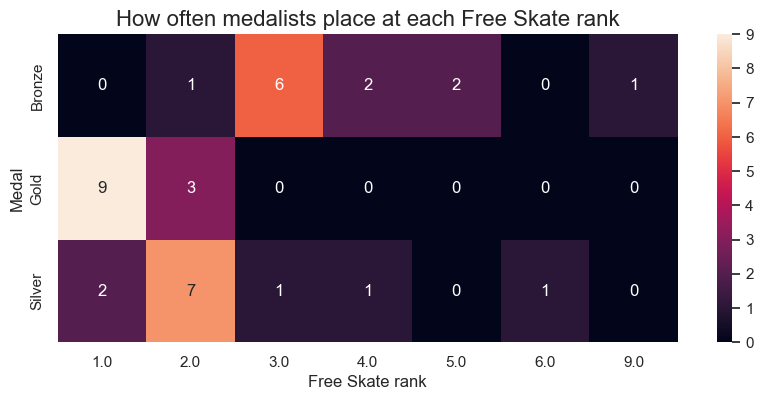

In [10]:
medalists_small = medalists[["year","gender","skater","nation","medal_label","sp_rank","fs_rank","final_rank"]].copy()
display(medalists_small.sort_values(["year","gender","final_rank"]).head(18))

# How often does the FS winner win Gold?
gold = medalists[medalists["medal"]==1]
fs_winner_gold_rate = (gold["fs_rank"]==1).mean()

print(f"Gold medalists who also won Free Skate: {fs_winner_gold_rate:.0%}")

# Heatmap: medal vs FS rank
pivot = medalists.pivot_table(index="medal_label", columns="fs_rank", values="skater", aggfunc="count").fillna(0)

plt.figure(figsize=(10,4))
sns.heatmap(pivot, annot=True, fmt=".0f")
plt.title("How often medalists place at each Free Skate rank")
plt.xlabel("Free Skate rank")
plt.ylabel("Medal")
plt.show()


---
## 10) The “clutch” insight: When does PCS decide the podium?

We compare **Gold vs Silver** in each Olympic year and gender.

- If TES difference is tiny but PCS difference is large, it suggests **PCS acted as the tiebreaker**.

We plot:

- **X:** (Gold TES_total − Silver TES_total)
- **Y:** (Gold PCS_total − Silver PCS_total)

---

In [11]:
def gold_silver_diffs(df):
    out=[]
    for (year,gender), grp in df.groupby(["year","gender"]):
        g = grp[grp["medal"]==1].iloc[0]
        s = grp[grp["medal"]==2].iloc[0]
        out.append({
            "year":year,
            "gender":gender,
            "tes_diff_g_s": g["tes_total"] - s["tes_total"],
            "pcs_diff_g_s": g["pcs_total"] - s["pcs_total"],
            "gold": g["skater"],
            "silver": s["skater"]
        })
    return pd.DataFrame(out)

gs = gold_silver_diffs(medalists)
display(gs)

fig = px.scatter(
    gs,
    x="tes_diff_g_s",
    y="pcs_diff_g_s",
    color="gender",
    text="year",
    hover_data=["gold","silver"],
    title="Gold vs Silver: TES difference vs PCS difference"
)
fig.add_hline(y=0, line_dash="dot")
fig.add_vline(x=0, line_dash="dot")
fig.update_traces(textposition="top center")
fig.show()


,year,gender,tes_diff_g_s,pcs_diff_g_s,gold,silver
0,2006,M,17.44,8.68,PLUSHENKO Evgeni,LAMBIEL Stephane
1,2006,W,7.70,-0.72,ARAKAWA Shizuka,COHEN Sasha
2,2010,M,-0.94,2.25,LYSACEK Evan,PLUSHENKO Evgeni
3,2010,W,16.82,6.24,KIM Yu-Na,ASADA Mao
4,2014,M,8.76,-2.29,HANYU Yuzuru,CHAN Patrick
5,2014,W,5.91,-0.43,SOTNIKOVA Adelina,KIM Yuna
6,2018,M,3.59,6.36,HANYU Yuzuru,UNO Shoma
7,2018,W,4.55,-3.24,ZAGITOVA Alina,MEDVEDEVA Evgenia
8,2022,M,18.49,4.06,CHEN Nathan,KAGIYAMA Yuma
9,2022,W,-2.92,6.14,SHCHERBAKOVA Anna,TRUSOVA Alexandra


---
## 11) Takeaways (draft)

Use this section to write your final story once you’ve looked at the charts.

Suggested structure:

1. **What wins overall?** (Hero chart)
2. **Has the sport shifted over time?** (Tech dominance trend)
3. **Does the FS decide medals?** (comeback/FS heatmap)
4. **When does PCS matter most?** (Gold vs Silver clutch chart)

Finish with one strong sentence that feels like a headline.

Examples:
- “At the Olympics, medals live where technical power is high — but PCS decides the tight races.”
- “Men’s gold is increasingly tech-driven; women’s podiums show more PCS leverage when TES is close.”

---

---
## 12) Export cleaned data for the interactive website

We’ll export:

- `olympics_singles_long.csv`
- `olympics_singles_agg.csv`
- a small `olympics_singles_agg.json` for fast loading in the website

---

In [ ]:
out_dir = Path("../site/data")
out_dir.mkdir(parents=True, exist_ok=True)

long.to_csv(out_dir / "olympics_singles_long.csv", index=False)
agg.to_csv(out_dir / "olympics_singles_agg.csv", index=False)

# JSON for the site
agg.to_json(out_dir / "olympics_singles_agg.json", orient="records")

print("Exported to:", out_dir.resolve())
